# Phase 1: ASK

## Objectives

**1. Business task:** 

How should the Brazilian E-commerce Olist improve it's profit margin, given that it has
- Some revenue per sellers per months
- Some revenues per orders
- Some reputation costs (estimated per bad reviews)
- Some operational costs of IT system that grows with number of orders, but not linearly (scale effects)

**2. Consider key stakeholders:**
- The main stakeholder is the CEO. 

**3. Deliverables:**

Produce a report with the following deliverables:
1. A clear summary of the business task
2. A description of all data sources used
3. Documentation of any cleaning or manipulation of data
4. A summary of your analysis
5. Supporting visualizations and key findings
6. Your top high-level content recommendations based on your analysis

## Assumptions
**Revenue**
* Olist takes a 10% cut on the product price (excl. freight) of each order delivered.
* Olist charges 80 BRL by month per seller.

**Cost**
* In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:

Review_cost
* 1 star	100
* 2 stars	50
* 3 stars	40
* 4 stars	0
* 5 stars	0


IT_cost
* Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.
* The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

## Data Description
The data is public data from the Brazilian E-Commerce data by Olist. The dataset has information of 100,000 orders from 2016 to 2018. The dataset includes order status, price, payment, freight performance to customer location, product attributes and reviews written by customers. It is very detailed database about the orders with each dimension segmented into different tables.

# Determine if Olist shold remove underperforming sellers from its marketplace

In this section, I will be focusing on evaluating the profitability for each sellers and determine if Olist should remove under-performing sellers from its marketplace. Under-performing sellers are sellers that does not bring sufficient revenue to cover the costs. 

## Prepare the data
- Given the cost and revenue assumptions above, I will extract the relevant data from various datasets to compute the profits for each sellers.

In [1]:
# import libraries
%load_ext autoreload
%autoreload 2

import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
# store all the datasets into a dictionary
def get_data():
    '''return a dictionary that consist of all the various Olist's dataset '''
    csv_path = os.path.join(os.path.dirname(os.getcwd()),'data','raw')
    file_names = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

    key_names = []
    for f in file_names:
        if f == 'product_category_name_translation.csv':
            key_names.append('product_category_name_translation')
        else:
            key_names.append(f[6:-12])
    data = {}
    for k, f in zip(key_names, file_names):
        data[k] = pd.read_csv(os.path.join(csv_path, f))
    return data

In [3]:
data = get_data()
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

In [4]:
# Extracting the right data from different tables to compute the profits.
def get_price_and_review():
    '''
    Return a Dataframe with:
    ['order_id', 'seller_id', 'price', 'review_score'] to compute the 10% commission revenue 
    and the review costs.
    '''
    df = data['order_items'][['order_id', 'seller_id', 'price']].merge(
        data['order_reviews'],
        on ='order_id', how ='outer')[[
        'order_id', 'seller_id', 'price', 'review_score'
    ]].dropna()
    return df


def get_quantity():
    '''
    Return a DataFrame with:
    ['n_orders'] to compute the IT costs
    '''
    df = data['order_items'].groupby('seller_id')\
    [['order_id']].nunique().rename(columns ={'order_id': 'n_orders'})
    return df 


def get_months():
    """
    Returns a DataFrame with
    ['seller_id', 'date_first_sale', 'date_last_sale', 'months_on_olist']
    to compute the monthly fees for Olist revenue. 
    """
    orders_approved = data['orders'][['order_id','order_approved_at']].dropna()

    orders_sellers = orders_approved.merge(data['order_items'],
                                               on='order_id')[[
                                                   'order_id',
                                                   'seller_id',
                                                   'order_approved_at'
                                               ]].drop_duplicates()

    orders_sellers["order_approved_at"] = pd.to_datetime(orders_sellers["order_approved_at"])

    orders_sellers["first_sale_date"] = orders_sellers['order_approved_at']
    orders_sellers["last_sale_date"] = orders_sellers['order_approved_at']

    # Compute first and the last sale date.
    df = orders_sellers.groupby('seller_id').agg({
        "first_sale_date": min,
        "last_sale_date": max,
    })

    # Compute the months on list
    df['months_on_olist'] = round((df['last_sale_date']-df['first_sale_date']) / np.timedelta64(1, 'M'))
    return df

In [5]:
# Compute the profits for each seller
def get_profits():
    """
    Returns a DataFrame with:
    'olist_revenue','olist_cost', 'olist_profit', 'months_on_list'
    """
    n_orders = get_quantity()
    df = get_price_and_review()
    months_on_olist = get_months()

    # comupte the review costs
    review_score_cost = {1:100, 2:50, 3:40, 4:0, 5:0}
    df['review_cost'] = df['review_score'].map(review_score_cost)

    # merge table with get_quantity and months_on_list
    df = df.groupby('seller_id').sum()
    df = df.merge(months_on_olist, on= 'seller_id', how= 'inner').merge(n_orders, on ='seller_id', how='inner')

    # compute the IT cost and the total cost
    df['it_cost'] = df['n_orders'].apply(lambda x: sqrt(x))
    factor = 500_000/df['it_cost'].sum()
    df['it_cost'] = df['it_cost'].apply(lambda x: x*factor)
    df['olist_cost']  = df['review_cost'] + df['it_cost']

    # compute the revenues
    df['olist_sale_revenue'] = df['price'] * 0.1
    df['olist_monthly_revenue'] = df['months_on_olist'] * 80
    df['olist_revenue'] = df['olist_sale_revenue'] + df['olist_monthly_revenue']

    # compute the profits
    df['olist_profit'] = df['olist_revenue'] - df['review_cost']
    df = df[['olist_revenue','olist_cost', 'olist_profit','months_on_olist']]

    return df

In [6]:
df = get_profits()

##  Analyse the pre-processed dataset
###  Key Objectives:

**1.Analyse the data**
- With the all the data combined into one dataset, I can visualize the distribution of seller's profit to gain some insights and evaluate the different solutions and recommend one to maximise Olist's profits.

(-5000.0, 5000.0)

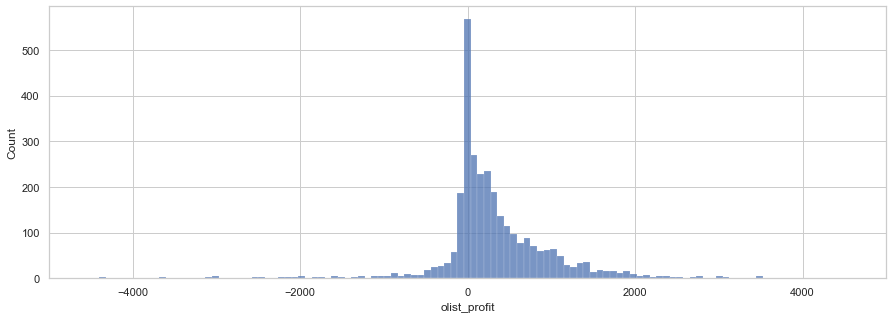

In [7]:
## Visualise the seller profit distribution
ax = plt.figure(figsize=(15,5))
sns.histplot(df['olist_profit'])
plt.xlim(-5000,5000)

**Analysis**
- It seems that the majority of the sellers are profitable and within the range \\$0 - \\$2000. The next step is to maximize the profits by removing all the under-performing sellers.

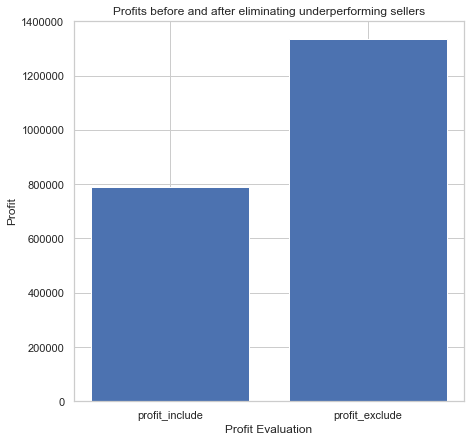

In [8]:
# Compute the overall profits before and after eliminating under-performing sellers
profit_include = df['olist_profit'].sum()
profit_exclude = df[df['olist_profit'] > 0]['olist_profit'].sum()
values = [profit_include,profit_exclude]
profits = ['profit_include', 'profit_exclude']

# plot the chart to visualize before and after eliminating under-performing sellers. 
plt.figure(figsize=(7,7))
plt.bar(profits,values)

plt.xlabel("Profit Evaluation")
plt.ylabel("Profit")
plt.title("Profits before and after eliminating underperforming sellers")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Analysis:**
- By excluding under-performing sellers, the profits increased by 68% from \\$790,922 to $1,335,670. However, looking at the seller's profit distribution, many under-performing sellers are close to breaking even. It does not seem fair to completely eliminate under-performing sellers because some sellers may have just started selling in Olist and it is reasonable give the sellers sufficient time to break even. Therefore, the next analysis is to evaluate the under-performing sellers distribution to determine which under-performing sellers should be removed.

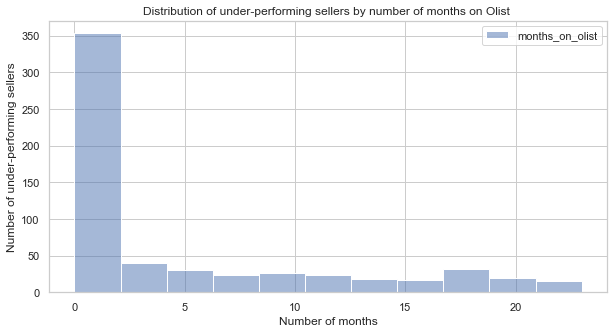

Total number of undeperforming sellers is 598


In [12]:
# Plotting the distribution of under-performing sellers by the number of months on Olist
plt.figure(figsize=(10,5))
sns.histplot(df[(df['olist_profit'] < 0)][['months_on_olist']])
num_underperforming_sellers = df[(df['olist_profit'] < 0)]['months_on_olist'].count()

plt.xlabel("Number of months")
plt.ylabel("Number of under-performing sellers")
plt.title("Distribution of under-performing sellers by number of months on Olist ")
plt.show()
print(f"Total number of undeperforming sellers is {num_underperforming_sellers}")

**Analysis:**
- From the visualisation above, more than half of the under-performing sellers are less than 5 months old in Olist. From this observation, we should not remove all the under-performing sellers despite that it won't maximize Olist profits.

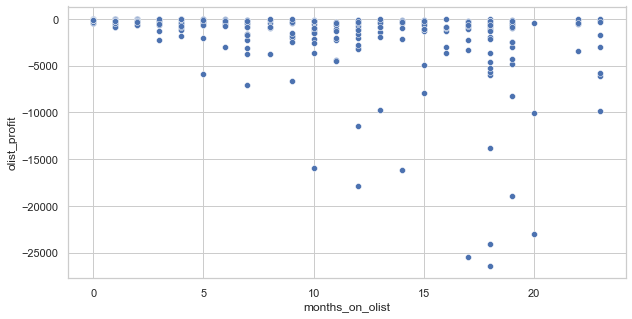

In [13]:
# Plotting a scatterplot on under-performing seller's profit against months on Olist.
plt.figure(figsize=(10,5))
under_performing_sellers_df = df[(df['olist_profit'] < 0)][['olist_profit','months_on_olist']]
sns.scatterplot(data = under_performing_sellers_df, x = 'months_on_olist', y = 'olist_profit')
plt.show()

**Analysis:**
- It seems that under-performing sellers that are less than 5 months on Olist are generally less costly compared to sellers that have been Olist for longer. A probable reason for this observation is that sellers that have stayed in Olist for a longer period of time will receive more reviews and this may translates to getting higher number of bad reviews and consequently, higher costs.
- Since under-performing sellers that only have been in Olist for 5 months don't incur more than \\$5,000, I have decided to only remove under-performing sellers that have been in Olist for more than 5 months.

In [14]:
# Compute a list of sellers that has been unprofitable and is in Olist for more than 5 months. 
seller_ids_remove = df[(df['olist_profit'] < 0) & (df['months_on_olist'] > 5)].index
# calculate the profits after excluding under-performing sellers that has been in Olist for more than 5 months.
profits_adjusted = df[~df.index.isin(seller_ids_remove)]['olist_profit'].sum()
print(f"Profits after removing under-performing sellers that have been in Olist for more than 5 months is ${profits_adjusted:,}")

Profits after removing under-performing sellers that have been in Olist for more than 5 months is $1,264,878.598


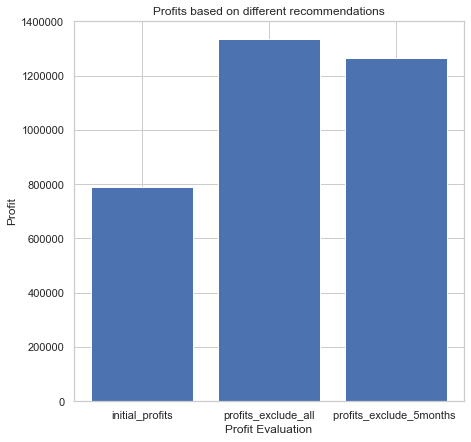

In [15]:
# Plot a graph to compare the profits based on different recommendations
profit_include = df['olist_profit'].sum()
profit_exclude_all = df[df['olist_profit'] > 0]['olist_profit'].sum()
profit_exlude_5months = df[~df.index.isin(seller_ids_remove)]['olist_profit'].sum()
values = [profit_include,profit_exclude, profit_exlude_5months]
profits = ['initial_profits', 'profits_exclude_all','profits_exclude_5months ']

plt.figure(figsize=(7,7))
plt.bar(profits,values)

plt.xlabel("Profit Evaluation")
plt.ylabel("Profit")
plt.title("Profits based on different recommendations")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Analysis:**
- The result of removing under-performing sellers that are only more than 5 months old in Olist, increases the profits by 60%, from \\$790,922 to \\$1,264,878 as seen from the chart above (profits_exclude_5months). Also it is worth mentioning that there is not a significant difference in profits from excluding all the under-performing sellers. 

- It is obvious that to maximize profit, Olist should completely remove under-performing sellers. However, this is impractical because removing recently joined sellers is unfair since it takes time to build traction and sales. Also, removing new sellers is detrimental to Olist's reputation and future sales because it discourages potential sellers from joining Olist. Hence, the recommended solution is to only remove under-performing sellers that have been in Olist for more than 5 months. 


# Analysing bad reviews 

Given that bad reviews are costly to Olist, it may be useful to explore what may affect customers to write bad reviews. 

In [17]:
# compute the unexpected delay for the customer to receive the goods, along with the expected duration for deliveries
def get_wait_time():
    """
    Return a Dataframe with 
    [order_id, wait_time, expected_wait_time, delayed_duration, order_status]
    """
    
    orders = data['orders']
    # transform columns to datetime
    orders['order_purchase_timestamp']  = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
    # compute the columns 
    orders['wait_time'] = orders['order_delivered_customer_date'].sub(orders['order_purchase_timestamp'])
    orders['expected_wait_time'] = orders['order_estimated_delivery_date'].sub(orders['order_purchase_timestamp'])
    orders['delayed_duration'] = orders['wait_time'].sub(orders['expected_wait_time'])
    
    # convert columns into days 
    orders['wait_time'] = orders['wait_time'] / np.timedelta64(1, 'D')
    orders['expected_wait_time'] = orders['expected_wait_time'] / np.timedelta64(1, 'D')
    orders['delayed_duration'] = orders['delayed_duration'] / np.timedelta64(1, 'D')
    # since we only care about the unexpected delays, those orders that are deliveries on time will be set to 0. 
    orders['delayed_duration'] = orders['delayed_duration'].apply(lambda x: x if x > 0 else 0)
    
    orders = orders[['order_id','order_status','wait_time','expected_wait_time','delayed_duration']]
    
    return orders

In [119]:
# utils
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of coordinates (lon1, lat1, lon2, lat2)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

def standardize(df, features):
    '''standardize the selected features'''
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [75]:
def get_distance_seller_customer():
    """
    Returns a DataFrame with:
    order_id, distance_seller_customer
    """
    
    # Merge customer and seller zip code into one dataframe
    combined_df = data['order_items'][['order_id','seller_id']].\
    merge(data['orders'][['order_id','customer_id']], on = 'order_id', how = 'left').\
    merge(data['customers'][['customer_id','customer_zip_code_prefix']], on ='customer_id', how= 'left').\
    merge(data['sellers'][['seller_id','seller_zip_code_prefix']], on ='seller_id', how ='left')
    
    # Groupby zip code since individual states has the same zip code and take the first one. 
    data['geolocation'] = data['geolocation'].groupby('geolocation_zip_code_prefix', as_index= False).first()
    
    # Get seller's longitude and latitude 
    combined_df = combined_df.merge(data['geolocation']
                  [['geolocation_zip_code_prefix','geolocation_lat', 'geolocation_lng']], 
                  left_on = 'seller_zip_code_prefix', right_on ='geolocation_zip_code_prefix', how = 'left').rename(
                  columns ={'geolocation_lat':'geolocation_lat_seller', 'geolocation_lng': 'geolocation_lng_seller'})
    
    
    # Get customer's longitude and latitude 
    combined_df = combined_df.merge(data['geolocation']
                  [['geolocation_zip_code_prefix','geolocation_lat', 'geolocation_lng']], 
                  left_on = 'customer_zip_code_prefix', right_on ='geolocation_zip_code_prefix', how = 'left').rename(
                  columns ={'geolocation_lat':'geolocation_lat_customer', 'geolocation_lng': 'geolocation_lng_customer'})
    
    # Get relevant columns 
    geolocation_df = combined_df[['order_id',
             'geolocation_lat_seller',
             'geolocation_lng_seller',
             'geolocation_lat_customer',
             'geolocation_lng_customer'
    ]].dropna()
    
    
    # Get distance from customer to seller 
    geolocation_df['distance_seller_customer'] =\
    geolocation_df.apply(lambda row:
                      haversine_distance(row['geolocation_lng_seller'],
                                         row['geolocation_lat_seller'],
                                         row['geolocation_lng_customer'],
                                         row['geolocation_lat_customer']), axis = 1)
    

    geolocation_df = geolocation_df[['order_id','distance_seller_customer']]
    
    return geolocation_df


In [123]:
# merged relevant data columns into one dataset to perform analysis 
distance_seller_customer_df = get_distance_seller_customer()
wait_time_df = get_wait_time()

final_df = data['order_reviews'][['order_id','review_score']]. \
                merge(wait_time_df, on ='order_id', how='left'). \
                merge(distance_seller_customer_df, on='order_id', how='left'). \
                merge(data['order_items'][['order_id','price','freight_value']], on='order_id', how='left').dropna()

final_df = final_df.groupby('order_id', as_index = False).first()

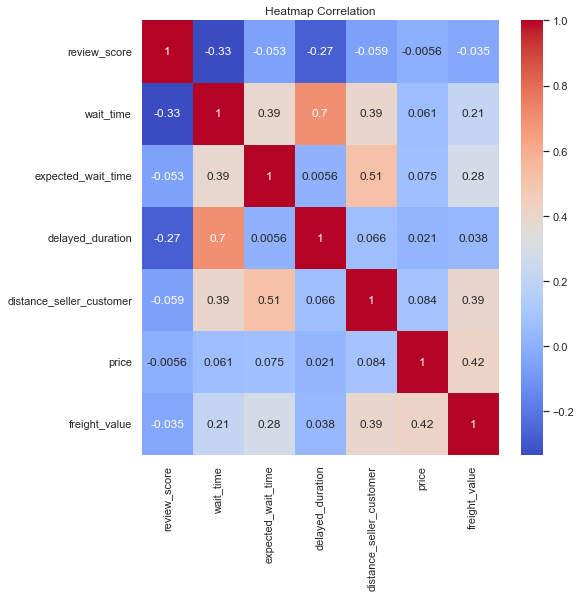

In [137]:
# visualise pairwise correlations of columns using heatmap.
plt.figure(figsize=(8,8))
sns.heatmap(final_df.corr(), annot = True,  cmap='coolwarm')
plt.title("Heatmap Correlation")
plt.show()

**Analysis:**
- From the correlation heatmap, it seems that wait_time and delayed_duration has the strongest negative correlation against review_score. There are no other significant correlation against review_score. Therefore, I will be prioritising on these two features to perform regression analysis on review_score. 

In [133]:
# standardize the selected features from the final_df
features = ['wait_time','delayed_duration','distance_seller_customer']
df = standardize(final_df,features)

In [131]:
# perform linear regression analyis 
formula = '''review_score ~ delayed_duration + wait_time '''
model = smf.ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6170.
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:39:26   Log-Likelihood:            -1.5340e+05
No. Observations:               95355   AIC:                         3.068e+05
Df Residuals:                   95352   BIC:                         3.068e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1559      0.004   1061.488      0.000       4.148       4.164
delayed_duration    -0.0948      0.006    -17.220      0.000      -0.106      -0.084
wait_time           -0.3631      0.006    -65.976      0.000      -0.374      -0.352
==============================================================================
Omnibus:                    19898.643   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40348.432
Skew:                          -1.249   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                         2.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Analysis and Interpretation:**
   - Both delayed_duration and wait_time are statistically significant given that the p-values are close to 0. However, R-squared is only 0.115. This implies that only 11.5% of the total variation in review_score is explained by the selected features. 
   - Also, both features have a negative relationship with review_score. This means that on average, if wait_time increases, the review_score will likely decrease, holding all other features constant. This makes sense because customers don't like having to wait for a long time.  
   - Given that an increase in wait_time has an adverse effect on order's review_score, it will be interesting to explore what causes a longer wait_time.

## Analysing wait_time

- Looking at the correlation heatmap, distance_seller_customer has strong correlation with wait_time. Both features; delayed_duration and expected_wait_time have a strong correlation with wait_time. However, they are linearly dependent with wait_time. Therefore, the delayed_duration and expected wait_time will not be considered. 


In [138]:
formula = '''wait_time ~ distance_seller_customer '''
model = smf.ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                 1.763e+04
Date:                Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                        20:50:03   Log-Likelihood:            -1.2722e+05
No. Observations:               95355   AIC:                         2.544e+05
Df Residuals:                   95353   BIC:                         2.545e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -6.078e-18      0.003  -2.04e-15      1.000      -0.006       0.006
distance_seller_customer     0.3950      0.003    132.765      0.000       0.389       0.401
==============================================================================
Omnibus:                    90998.546   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9971434.058
Skew:                           4.335   Prob(JB):                         0.00
Kurtosis:                      52.341   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Analysis and Interpretation:**
   - Distance_seller_customer are statistically significant since the p-value is approximately 0. The R-squared is 15.6%. 
   - Also, distance_seller_customer has a positive relationship with wait_time. This means that on average, as the distance between the seller and customer increases, the review_score will increase, holding all other features constant. This observation is logical as you would expected the duration to increase when there is a greater distance to travel to get to the customer. 


In [292]:
# create bins of distance_seler_customer to determine which bins has the highest 1 review_score ratio. 
min_ = final_df['distance_seller_customer'].min()
max_ = final_df['distance_seller_customer'].max()

bins = np.linspace(min_,max_,4)
labels = np.arange(3)
final_df['bins'] = pd.cut(final_df['distance_seller_customer'], bins = bins, labels= labels, include_lowest=True)

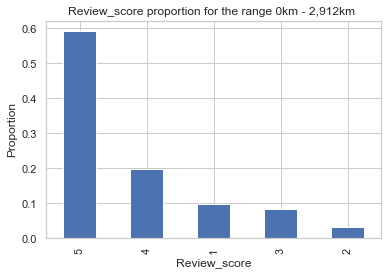

95179 orders are within the range above
 


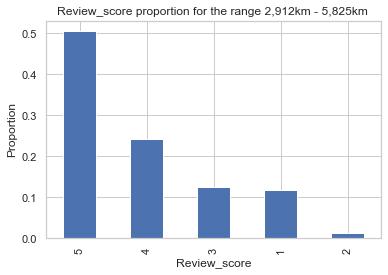

170 orders are within the range above
 


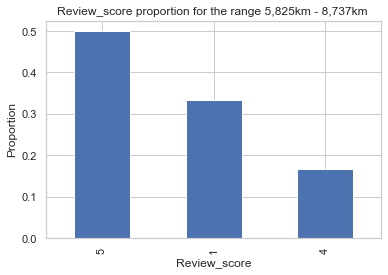

6 orders are within the range above


In [293]:
# visualise the proportion of review scores within each bins 
for i in range(len(labels)):
    # range_ variable stores the bin values 
    range_ = f"{round(bins[i]):,}km - {round(bins[i+1]):,}km "
    # calculate the review_score proportion for each bins
    x = final_df[final_df['bins'] == i ]['review_score'].value_counts()\
    /final_df[final_df['bins'] == i ]['review_score'].count()
    # execute if bin has no orders, else display a barplot of the proportions. 
    if x.empty == True:
        print(" ")
        print(f"There are no orders within the range {range_}")
        continue
    else:
        x.plot.bar()
        plt.xlabel('Review_score')
        plt.ylabel('Proportion')
        plt.title(f"Review_score proportion for the range {range_}")
        print(" ")
        plt.show()
        print(f"{final_df[final_df['bins'] == i ]['review_score'].count()} orders are within the range above")

**Analysis:**
- The charts above have clearly shown that as the distance increases, the proportion of one stars reviews increases. Looking at the last chart that represents that furtherest distance (5825km - 8,747km), the proportion of one star reviews is more than 30%. Therefore, it is advised to not allow sales if the distance is more than 5825km.
- It is important to note that the last range (5825km - 8,747km) only has 6 orders. Therefore, even after implementing the recommendation, Olist may not see a substantial increase in profits

# Recommendation

**Olist can improve its profit margin by**
- Removing under-performing sellers that have been more in Olist for more than 5 months. This recommendation saved more than half of the under-performing sellers, giving them the opportunity to gain traction and increase sales for Olist. At the same time, this recommendation preserves Olist's reputation.
- Prevent sales if distance between customer and sellers more than 5,825km, so that customers will less likely experience delays, which reduces the likelihood of receiving bad reviews.  Through this recommendation, Olist can determine which seller/customer pairs between certain states to restrict. 

**Moving Forward**
- Analyze the reviews using Natural Language processing techniques to determine why customers give bad and good reviews. The objective will be to cluster the topics in the review data section.